In [91]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

#set the name of the column that contain the dependent variable y.
y_column = 'meanOpinionScore'

#Read data from CSV
sessionRegressionDF = pd.read_csv('data/sessionRegressionDF.csv', delimiter = ',')

# Ignore some columns if needed
sessionRegressionDF = sessionRegressionDF.drop(columns=["qosItems_IPL_Subnet_L2", "qosItems_IPR_Subnet_L2"])

# ##############################################
# Keep only values from the "Bad" calls, where 1 < MOS < 3.5
sessionRegressionDF = sessionRegressionDF[(sessionRegressionDF.meanOpinionScore < 3.5) & (sessionRegressionDF.meanOpinionScore > 1)]

# ##############################################
# Remove all rows that MOS is NaN
sessionRegressionDF = sessionRegressionDF.dropna(subset=[y_column])


# ##############################################
# Remove all columns that the number of blank values is > 50%
countOfNaN = sessionRegressionDF.isna().sum()
columnstoDrop = []
for columnIndex in sessionRegressionDF.columns:
    total_rows = sessionRegressionDF[columnIndex].count() + 1
    if countOfNaN[columnIndex] > (0.5 * total_rows):
        columnstoDrop.append(columnIndex)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)

# ##############################################
# Update the independent variables that will be used and then drop all rows that the feature's value is NaN 
independentVariables = list(sessionRegressionDF.columns)
sessionRegressionDF = sessionRegressionDF.dropna(subset = independentVariables)


### ##################################################
# Identify the columns that contain Categorical and Nummeric data.
categoricalColumns = []
numericColumns = []
# Replace the String values with a Enumeration
for colDependencies in sessionRegressionDF.columns:
    columnDataType = sessionRegressionDF.dtypes[colDependencies]
    if(columnDataType == 'object'):
        categoricalColumns.append(colDependencies)
    else:
        numericColumns.append(colDependencies)
        
# Create dummy values for columns that contain Categorical data 
sessionRegressionDF = pd.get_dummies(sessionRegressionDF, columns=categoricalColumns)

# MinMaxScaler preserves the shape of the original distribution. 
# It doesn't meaningfully change the information embedded in the original data. 
# Note that MinMaxScaler doesn't reduce the importance of outliers. 
# The default range for the feature returned by MinMaxScaler is 0 to 1
scaler = MinMaxScaler()
sessionRegressionDF[numericColumns] = scaler.fit_transform(sessionRegressionDF[numericColumns])


### ##################################################
# Remove columns that its variance is 0.0. These variables are not affecting the Y
columnstoDrop = []
for colDependencies in sessionRegressionDF.columns:
    variance = sessionRegressionDF.var()[colDependencies]
    if variance == 0.0:
        columnstoDrop.append(colDependencies)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)


# Remove outliers using the z-score
sessionRegressionDF = sessionRegressionDF[(np.abs(stats.zscore(sessionRegressionDF)) < 2.5).all(axis=1)]


# Calculate the correlation between all variables and remove one of them if the correlation is > 0.8
sessionRegressionDF_without_y = sessionRegressionDF.drop(columns=[y_column])
correlation_matrix = sessionRegressionDF_without_y.corr().round(2).abs()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))
columnstoDrop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)


# ##################################################
# Set the Target (Y) to 'meanOpinionScore' and then delete the meanOpinionScore from the list of independent variables
target = pd.DataFrame(sessionRegressionDF[y_column], columns=[y_column])
sessionRegressionDF = sessionRegressionDF.drop(columns=[y_column])

# ##################################################
# Update the list of independent variables based on the latest calculations
independentVariables = list(sessionRegressionDF.columns)


# ##################################################
# Create the model

X = sessionRegressionDF[independentVariables]
Y = target[y_column]

X_Const = sm.add_constant(X)

model = sm.OLS(Y, X_Const)
regressionResult = model.fit()

# ##################################################
# Print out the statistics
regressionResult.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       meanOpinionScore   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     526.1
Date:                Fri, 13 Aug 2021   Prob (F-statistic):          2.78e-246
Time:                        11:44:00   Log-Likelihood:                 754.58
No. Observations:                 476   AIC:                            -1487.
Df Residuals:                     465   BIC:                            -1441.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
qosItems_LA            -1.1005      0.417     -2.637      0.009      -1.921      -0.280
qosItems_PLLP           0.0956      0.184      0.519      0.604      -0.266       0.458
qosItems_PLRP          -3.7139      0.053    -69.543      0.000      -3.819      -3.609
qosItems_JI            -0.0803      0.033     -2.422      0.016      -0.146      -0.015
qosItems_ST_G722     2.251e-15   1.06e-15      2.125      0.034    1.69e-16    4.33e-15
qosItems_ST_PCMA        0.2549      0.004     64.805      0.000       0.247       0.263
qosItems_ST_PCMU        0.2455      0.005     52.166      0.000       0.236       0.255
qosItems_ST_opus        0.1037      0.003     33.144      0.000       0.098       0.110
qosItems_LCT_host    -7.49e-16   3.08e-16     -2.434      0.015   -1.35e-15   -1.44e-16
qosItems_LCT_prflx  -1.541e-16   6.85e-17     -2.248      0.025   -2.89e-16   -1.94e-17
qosItems_LCT_relay      0.0010      0.005      0.191      0.849      -0.010       0.012
qosItems_RCT_host       0.6041      0.004    152.976      0.000       0.596       0.612
qosItems_RCT_relay           0          0        nan        nan           0           0
qosItems_RCT_srflx           0          0        nan        nan           0           0
qosItems_UD_Android     0.1539      0.004     38.282      0.000       0.146       0.162
qosItems_UD_Win32       0.3016      0.004     84.997      0.000       0.295       0.309
qosItems_UD_iOS         0.1486      0.003     45.121      0.000       0.142       0.155
qosItems_NI_wlan        0.1582      0.003     47.310      0.000       0.152       0.165
qosItems_NI_wwan        0.1443      0.005     29.593      0.000       0.135       0.154
==============================================================================
Omnibus:                       35.659   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.334
Skew:                           0.525   Prob(JB):                     5.85e-13
Kurtosis:                       4.319   Cond. No.                     1.63e+33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.67e-64. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [92]:
print("List of parameters ordered by abs(coef) and p-value < 0.05")
lowPvalues = regressionResult.pvalues[regressionResult.pvalues < 0.005]
lowPvaluesNames = lowPvalues.index.tolist()
listOfSignificantFactors = regressionResult.params.filter(items=lowPvaluesNames).abs().sort_values(ascending=False).index.tolist()

print(regressionResult.params.filter(items=listOfSignificantFactors))

List of parameters ordered by abs(coef) and p-value < 0.05
qosItems_PLRP         -3.713869
qosItems_RCT_host      0.604101
qosItems_UD_Win32      0.301595
qosItems_ST_PCMA       0.254915
qosItems_ST_PCMU       0.245516
qosItems_NI_wlan       0.158156
qosItems_UD_Android    0.153866
qosItems_UD_iOS        0.148640
qosItems_NI_wwan       0.144350
qosItems_ST_opus       0.103670
dtype: float64


<AxesSubplot:>

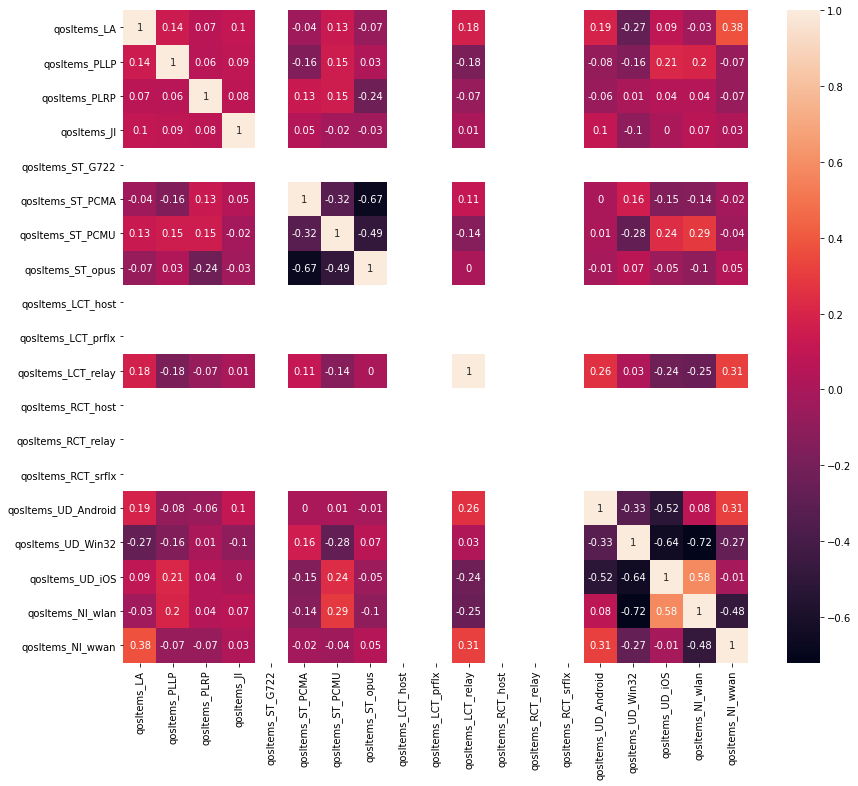

In [93]:
correlation_matrix = sessionRegressionDF.corr().round(2)
plt.figure(figsize=(14, 12))  
sns.heatmap(data=correlation_matrix, annot=True)

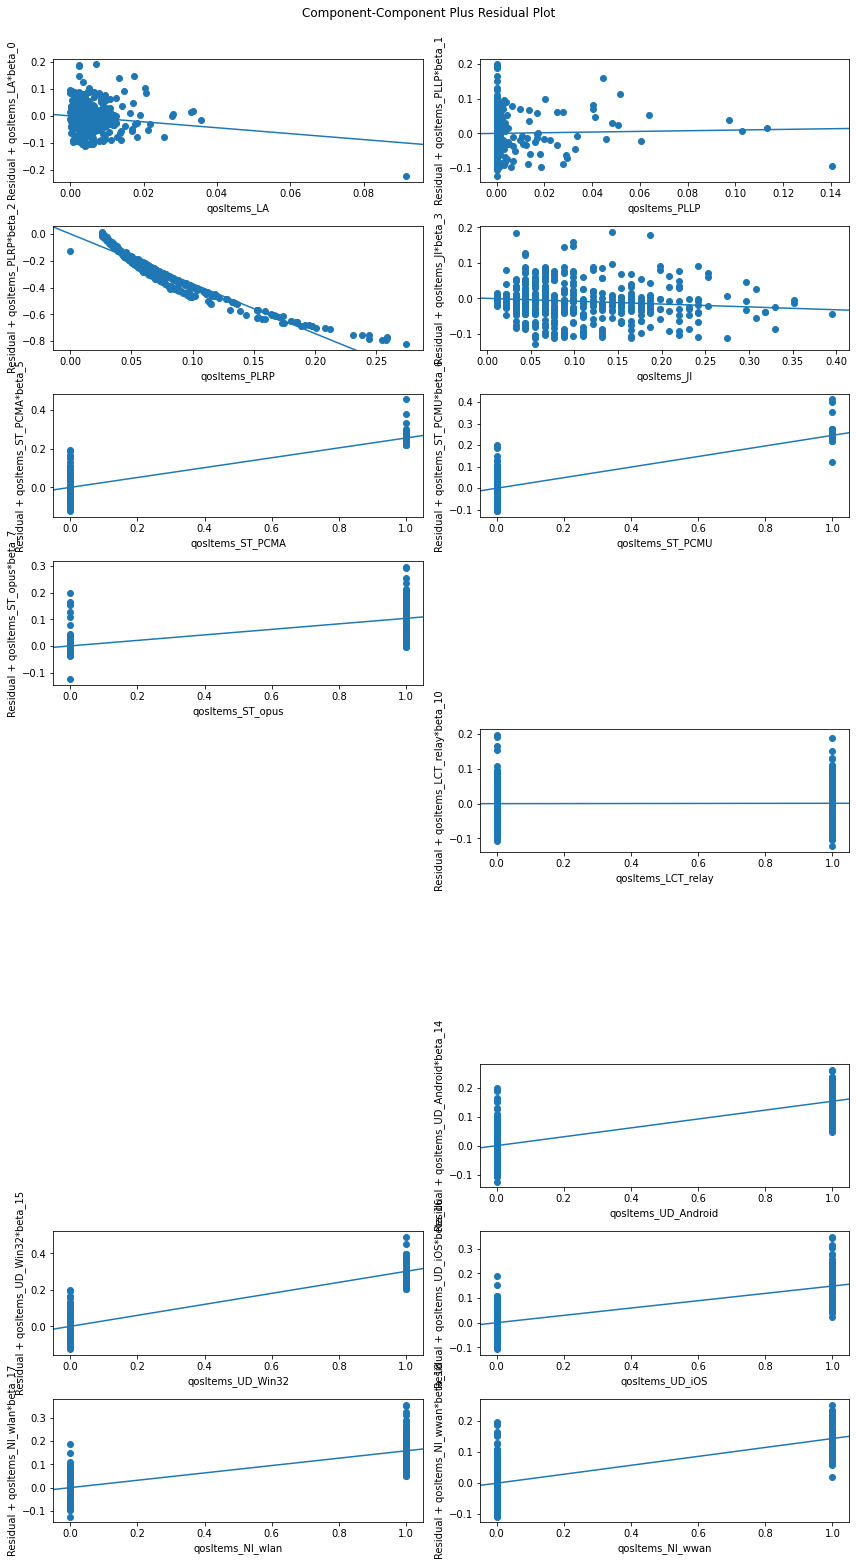

In [94]:
fig = plt.figure(figsize=(12, 24))
fig = sm.graphics.plot_ccpr_grid(regressionResult, fig=fig)